In [1]:
%pip install anytree

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import pickle
from pathlib import Path
import os
import pprint
from anytree import Node, RenderTree
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

For future iterations of this I might change the scheme to a deep directory based approach.    
Then iterations would be named `1.pickle`, `2.pickle` and be stored in deep directories like:    
`"Experiment_name/config1/config2/config3/config4/1.pickle"`    
This way I could just split the name accross the folder separator and have all the setting values, then the only thing I need is a list that gives me the correct setting-value assignment, which sounds a lot easier.

# Helper functions

In [3]:
def unpickle(filepath : str):
    file_object = open(filepath, "rb")
    results = pickle.load(file_object)
    file_object.close()
    return results

In [4]:
def extract_setting_from_name(name :str, naming_schema : list):
    result = {}
    # Main assumption for the naming schema: parameters are strictly separated by underscores '_'
    for value, setting in zip(name.split("_"), naming_schema):
        result[setting] = value
    return result
    

In [5]:
def load_results(directory, experiment_name, naming_schema=None, regex_scheme=None):
    path = Path(directory)

    dirs = [e for e in path.iterdir() if e.is_dir() and not str(e) == '.ipynb_checkpoints']
    subdirs = {str(path): [e for e in path.iterdir() if e.is_dir()] for path in dirs}
    
    relevant_subdirs = subdirs[os.path.join(directory, experiment_name)]
    relevant_subdirs.sort()
    #result_filename = '*.pickle'
    pickle_dirs = list()
    for subdir in relevant_subdirs:
        if regex_scheme:
            pickle_dirs.extend(sorted(subdir.glob(regex_scheme)))
        else:
            pickle_dirs.extend(sorted(subdir.glob("*.pickle")))
    results = []
    if not naming_schema is None:
        all_attributes = [extract_setting_from_name(subdir.name, naming_schema) for subdir in relevant_subdirs]    
        for attributes, pick in zip(all_attributes, pickle_dirs):
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'attributes': attributes, 'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    else:
        for pick in pickle_dirs:
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    return results


In [6]:
def deep_dict_get(data : dict, path : str):
    """
    path a slash ('/') separated path down to 
    """
    temp = data.copy()
    for entry in path.split("/"):
        # Catches leading '/' in tree printing
        if entry == '':
            continue
        temp = temp[entry]
    return temp

In [7]:
def compare_values(d1 : dict, d2 : dict, path : str):
    v1 = deep_dict_get(d1, path)
    v2 = deep_dict_get(d2, path)
    # Sanity check 1
    if not type(v1) == type(v2):
        return False
    else:
        # This can potentially cause errors when comparing lists of lists (or Tensors/Arrays)
        return v1 == v2

In [8]:
def create_common_root_list(root : str, values : list):
    return [f"{root}/{val}" for val in values]

# Main functions    
What features do I need?    
- ~~Show a structure tree of the results (i.e. experiment settings and result values)~~~
- ~~Filtering by setting, given a key~~
- ~~Filtering by values, given a key~~
- Create selected statistics (mean/med/std/quartiles/...) for certain values/keys
- Apply a function to certain values/keys and return the results (e.g. Eigendecomposition/Normalization/...)
- ~~Group all entries that share settings/values~~
- 

In [9]:
def generate_tree_structure(data, parent=None):
    # Solved through recursively going deeper into the data structure and then returning the leafs if at the end

    if parent is None and not len(data.keys()) == 1:
        parent = Node("root")
    elif parent is None:
        parent = Node(list(data.keys())[0])
        data = data[list(data.keys())[0]]
    
    # Recursion condition
    # If there are any dictionaries inside then go deeper
    if not any([type(data[entry]) == dict for entry in data]):
        for entry in data:
            Node(entry, parent=parent) 
    else:
        for entry in data:
            if type(data[entry]) == dict:
                branch = Node(entry, parent=parent)
                generate_tree_structure(data[entry], parent=branch)
            else:
                Node(entry, parent=parent)
    return parent
    

In [10]:
def group_by(list_of_data : list, path, value=None):
    """
    value : If None, make subgroups of equal values. 
            Otherwise return a single group where value is matched
    """
    grouped_data = {}

    if not value is None:
        grouped_data[f"{path} = {value}"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
    else:    
        finished_values = list()
        for data in list_of_data:
            value = deep_dict_get(data, path)
            if f"{path} = {value}" in grouped_data.keys():
                grouped_data[f"{path} = {value}"].append(data)
            else:
                grouped_data[f"{path} = {value}"] = list()
                grouped_data[f"{path} = {value}"].append(data)
            #if not value in finished_values:
            #    grouped_data[f"{path} = value"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
            #    finished_values.append(value)
    return grouped_data

In [11]:
def dict_compare(d1, d2):
    # Checking for empty list in d2, i.e. initial value
    if not type(d1) == type(d2):
        return False
    return all((d1.get(k) == v for k, v in d2.items()))
        

# Could contain an alternative head as (list_of_data : list, paths : [list, dict], values : None) 
# where paths-values would require a 1-to-1 correspondence. 
# But this could quickly become error prone on the user side...
def group_by_multiple(list_of_data : list, paths):
    grouped_data = {}
    # Grouping without values
    if type(paths) == list:
        finished_values = list()
        for data in list_of_data:
            paths_vals = {path : deep_dict_get(data, path) for path in paths}
            # not any X <=> all not X
            # i.e. only succeeds when this combination didn't exist before
            if not any([dict_comapare(paths_vals, fin_val) for fin_val in finished_values]):
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])] = [data]
            else:
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])].append(data)

    # Grouping by path-value combinations
    # Only returns the group where all those pairs are true
    elif type(paths) == dict:
        # The keys will contain the paths
        # The values will be the corresponding expected values
        # Yes, this could be a one-liner with a very neat nested list creation, 
        #  but I chose readability with temporary variables over it.
        good_data = list()
        for data in list_of_data:
            if all([deep_dict_get(data, path) == paths[path] for path in paths]):
                good_data.append(data)
        grouped_data[" ; ".join([f"{path} = {paths[path]}" for path in paths])] = good_data
    return grouped_data

In [12]:
def filter_by(list_of_data : list, path : str, value):
    filtered_data = list()
    for data in list_of_data:
        if deep_dict_get(data, path) == value:
            filtered_data.append(data)
    return filtered_data

In [13]:
def filter_value(list_of_data : list, path : str):
    """
        returns a list of the target value from each data dict
    """
    list_of_values = list()
    for data in list_of_data:
        list_of_values.append(deep_dict_get(data, path))
    return list_of_values

# Load results

In [ ]:
#naming_schema = ["Metric", "Kernel_search", "train_data_ratio", "Data_kernel", "weights", "Variance_list", "eval_START", "eval_END", "eval_COUNT", "optimizer", "train_iterations", "LR", "Noise", "Data_scaling", "BFGS"]
#all_results = load_results('results', "hardcoded", regex_scheme="other_datasizes.pickle")
#all_results = load_results('results', "hardcoded", regex_scheme="LapCor00.pickle")
#all_results = load_results('results', "hardcoded", regex_scheme="LapCorBIC.pickle")
#all_results = load_results('results', "hardcoded", regex_scheme="LLapCor00.pickle")
all_results = load_results('results', "hardcoded", regex_scheme="LLapCorBIC.pickle")

postfix = "_BIC"
#pprint.pprint(all_results)
result_tree = generate_tree_structure(all_results[0]).descendants
#pprint.pprint(result_tree)


# data - kernel assignment : RBF_PER = SIN*RBF; 4PER = 4C*SIN; PER = C*SIN
# Perform for each main dictionary: Iterate over kernels -> Look for the lowest(highest?) loss, 

"""
for main_dict in all_results:
    print("############################")
    print(main_dict["results"]["attributes"]["data_gen"])
    for model_kernel in ['C*C*RBF','C*RBF','C*SIN','C*SIN + C*SIN','C*SIN + C*SIN + C*SIN','SIN*RBF']:
        print("\n----")
        print(f"{model_kernel}:\n")
        for metric in ["Laplace", "MC", "MLL", "AIC"]:
            print(f"{metric}\t - \t{main_dict['results'][metric][model_kernel]['loss']}")

"""

# What do I want to know?
# 1.) Does each metric recognize the correct kernels?
# 1.1.) If not: Why?
# 2.) Is the order I was talking about true?
# 2.1.) i.e. MLL > Laplace/AIC >=? MCMC
# 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case
# 4.) Make a ranking sheet per dataset where the models are compared _within_ a metric to see if there are similarities visible or something
#  
data_kernels = ["SE", "MAT32","MAT32+SE", "MAT32*SE"]#, "PER*SE", "MAT32+PER"] # "PER",
#data_kernels = ["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE"]
model_kernels = [ "SE", "MAT32", "MAT32+SE", "MAT32*SE", "C*C*SE"] # "PER", 
#model_kernels = ["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE", "C*C*SE"]
#metrics = ["MC", "AIC", "BIC", "Laplace", "Laplace_prior"]# "MLL", "MAP"
metrics = ["Laplace"]# "MLL",
#metrics = ["Laplace_prior"]# "MLL",
dataset_sizes = [10, 20, 50, 70, 100, 150, 200]
data_model_zip = zip(data_kernels, model_kernels[:-1])

print("1.) Does each metric recognize the correct kernel?")
# 1.) Does each metric recognize the correct kernel?
# Iterate over all datasets
results_table = {datasize: {f"{metric}{postfix}":{"RR": list(), "RR3":list(), "runtime": -1} for metric in metrics} for datasize in dataset_sizes} 
#for main_dict in all_results:
# Iterate over all kernels I tried
#for model_kernel in ['C*C*RBF','C*RBF','C*SIN','C*SIN + C*SIN','C*SIN + C*SIN + C*SIN','SIN*RBF']:
#print(main_dict["results"]["attributes"]["data_gen"])
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        if not deep_dict_get(result, "results/attributes/data_gen") in data_kernels:
            continue
        for metric in metrics:
            if result["results"]["attributes"]["data_gen"] == max([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[-1]:
                results_table[data_num][f"{metric}{postfix}"]["RR"].append(True)
            else:
                results_table[data_num][f"{metric}{postfix}"]["RR"].append(False)
            sorted_results = sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels], key=lambda x:x[0], reverse=True)
            top3 = sorted_results[:3]#sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[:3]
            if result["results"]["attributes"]["data_gen"] in [t[1] for t in top3]:
                results_table[data_num][f"{metric}{postfix}"]["RR3"].append(True)
            else:
                results_table[data_num][f"{metric}{postfix}"]["RR3"].append(False)
    #print(f"{metric}\t {max([(main_dict['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])}")

print("===============================")
print("2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?")
# 2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?
#     It should be ordered AIC > MLL > Laplace
#     And somewhere in between there should be MC
# Iterate over all datasets
for main_dict in all_results:
    print(main_dict["results"]["attributes"]["data_gen"])
    # Do this comparison for each model kernel
    #["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE"]
    for model_kernel in model_kernels:
        ranking = [(main_dict['results'][metric][model_kernel]['loss'], metric) for metric in metrics]
        ranking = sorted(ranking, key=lambda x:x[0], reverse=True)
        # Check if it either is MLL > Laplace > AIC (this happens if MLL is negative) OR AIC > MLL > Laplace 
        #if not (main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss'] > main_dict['results']["AIC"][model_kernel]['loss']) and not (main_dict['results']["AIC"][model_kernel]['loss'] > main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss']) :
        print(f"{model_kernel}\t {ranking}")

#print("===============================")
#print("3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case")
## 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case 
#
## Iterate over all datasets
#for main_dict in all_results:
#    for metric in ["Laplace", "AIC", "Laplace_prior"]:
#        print(metric)
#        for pair in data_model_zip:#[('C*RBF', 'C*C*RBF'), ('C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN + C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN', 'C*SIN + C*SIN')]:
#            met_1 = main_dict['results'][metric][pair[0]]['loss'] 
#            met_2 = main_dict['results'][metric][pair[1]]['loss'] 
#            if not met_1 > met_2:
#                print(f"{main_dict['results']['attributes']['data_gen']} \t - {pair}")
        

print("===============================")
print("4.) Make a ranking per dataset how each model kernel was rated")

# 4.) Make a ranking per dataset how each model kernel was rated 
# Iterate over all datasets
confusion_matrix_data = {datasize: {f"{metric}{postfix}":{data_kernel : None for data_kernel in data_kernels} for metric in metrics} for datasize in dataset_sizes} 
for data_num in dataset_sizes:
    print(data_num)
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        print(result["results"]["attributes"]["data_gen"])
        for metric in metrics:
        # Do this ranking for each metric 
            print(metric)
            ranking = [(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels] 
            key_fkt = lambda x: x[0]
            pprint.pprint(sorted(ranking, key=key_fkt, reverse=True))

            def div2(input, doit):
                if doit:
                    return input/2
                else:
                    return input

            confusion_matrix_data[data_num][f"{metric}{postfix}"][result["results"]["attributes"]["data_gen"]] = [div2(result['results'][metric][model_kernel]['loss'].item(), metric in ["AIC", "BIC"]) for model_kernel in model_kernels]
            print("===============")

print("===============================")
print("5.) Runtime of each metric")

# Do this ranking for each metric 
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        for metric in metrics:
            #print(metric)
            if metric in ["Laplace", "Laplace_prior", "BIC"]:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] + result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            elif metric in ["MLL", "MAP"]:
                runtime_list = [result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            else:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] for model_kernel in model_kernels] 
            results_table[data_num][metric]["runtime"] = np.average(runtime_list)

        




In [ ]:

print(" & ".join(["MC", "AIC", "BIC", "Laplace", "Laplace_prior"]))
print(" & ".join(list(all_the_results_tables[data_num].keys())))
for data_num in all_the_results_tables:
    result_line = f"\\multirow{{3}}{{*}}{{{data_num}}} & "
    for criterium in ["RR", "RR3", "runtime"]:
        result_line += f"{criterium}"
        for metric in all_the_results_tables[data_num]:
            if criterium in ["RR", "RR3"]:
                result_line += f" & {np.round(100*np.count_nonzero(all_the_results_tables[data_num][metric][criterium])/len(all_the_results_tables[data_num][metric][criterium]), 2)}"
            else:
                result_line += f" & {np.round(all_the_results_tables[data_num][metric][criterium], 2)}"
        result_line += "\\\\"
        print(result_line)
        result_line = " & "
    print("\\midrule")

In [ ]:
#all_the_results_tables = copy.deepcopy(results_table)
#all_the_results_tables_bak = copy.deepcopy(all_the_results_tables)
all_the_results_tables = {data_num: dict(list(all_the_results_tables[data_num].items()) + list(results_table[data_num].items())) for data_num in all_the_results_tables}

In [ ]:
all_the_results_tables

In [ ]:

#all_the_confusion_results_bak = copy.deepcopy(all_the_confusion_results)

In [ ]:
#import copy
#all_the_confusion_results = copy.deepcopy(confusion_matrix_data)
#all_the_confusion_results = copy.deepcopy(all_the_confusion_results_bak)

In [ ]:
all_the_confusion_results = {data_num: dict(list(all_the_confusion_results[data_num].items()) + list(confusion_matrix_data[data_num].items())) for data_num in all_the_confusion_results}

In [ ]:
all_the_confusion_results

In [ ]:
fig, axs = plt.subplots(len(dataset_sizes), len(all_the_confusion_results[10]), sharey=True)
all_conf_matr_data = list()
#fig, axs = plt.subplots(1, 3, sharey=True)
for row, data_num in enumerate(dataset_sizes):#enumerate(confusion_matrix_data):
    all_conf_matr_data = list()
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
    minmin = np.min(np.array(all_conf_matr_data).flatten())
    maxmax = np.max(np.array(all_conf_matr_data).flatten())
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        #all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
        im = axs[row, col].matshow([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels], vmin=minmin, vmax=maxmax)
        #fig.colorbar(axs[row, col].matshow(single_conf_matr_data), cmap=plt.cm.GnBu)
        if row == 0:
            axs[row, col].set_xticks(range(len(model_kernels)))
            axs[row, col].set_xticklabels(model_kernels, rotation=90)
            axs[row, col].set_title(metric)
        else:
            axs[row, col].set_xticks([])
        axs[row, col].set_yticks(range(len(data_kernels)))
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].set_yticklabels(data_kernels)
    plt.colorbar(im)
        

#fig.colorbar(np.array(all_conf_matr_data))
#plt.colorbar(im)
fig.set_figwidth(30)
fig.set_figheight(15)
#plt.legend()

tikzplotlib.save("evaluation/confusion_matrix/allConfusionMatrix.tex")


In [ ]:
plt.close()

In [ ]:
results_dict = {}
metrics = ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]
kernel_recognition_dict = {data_num : {metric : {"1" : 0, "2" : 0} for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]:#, 100, 250, 500]:
    print("======================")
    results_dict[data_num] = {}
    print(data_num)
    # Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
    kernel_distributions = {}
    for key in ["Laplace", "AIC", "BIC", "Laplace_prior"]:#MLL
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-29].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        #pprint.pprint(result_tree)
        #total_runs = len(all_results[0])
        #print(all_results[0]['results']['attributes']['Data_kernel'])
        #winners = group_by(all_results, 'results/results/final model', value='(c * PER)')['results/results/final model = (c * PER)']
        data_kernels = [("SE", "(c * SE)"), ("RQ", "(c * RQ)"), ("PER", "(c * PER)"), ("MAT32", "(c * MAT32)"), ("PER*SE", "((c * PER) * (c * SE))"), ("PER+SE", "((c * PER) + (c * SE))"), ("MAT32*PER", "((c * MAT32) * (c * PER))"), ("MAT32+PER", "((c * MAT32) + (c * PER))"),("MAT32+SE", "((c * MAT32) + (c * SE))"),("MAT32*SE", "((c * MAT32) * (c * SE))")]
        data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)
 
        kernel_distributions[key] = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/results/final model')
        if key in ["Laplace", "Laplace_prior"]:
            data_500 = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/attributes/parameter_punishment')
            for punish_key in list(data_500.keys()):
                sum_recognized = 0
                sum_total = 0
                all_results = data_500[punish_key]
                for data_kernel, goal_kernel in data_kernels:
                    print(f"Data: {data_kernel}; Punish: {punish_key.split('=')[-1][1:]}")
                    total_runs = group_by(all_results, '/results/attributes/Data_kernel', data_kernel)
                    #SE_count = group_by(all_results, '/results/results/final model', "(c * SE)")
                    #mat32_count = group_by(all_results, '/results/results/final model', "(c * MAT32)")
                    #mat52_count = group_by(all_results, '/results/results/final model', "(c * MAT52)")
                    #print(f"SE count: {len(SE_count[f'/results/results/final model = (c * SE)'])}")
                    #print(f"MAT32 count: {len(mat32_count[f'/results/results/final model = (c * MAT32)'])}")
                    #print(f"MAT52 count: {len(mat52_count[f'/results/results/final model = (c * MAT52)'])}")
                    winners = group_by_multiple(all_results, {'/results/attributes/Data_kernel' : data_kernel, 'results/results/final model' : goal_kernel})
                    print(f"Recognized {len(winners[f'/results/attributes/Data_kernel = {data_kernel} ; results/results/final model = {goal_kernel}'])} of {len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])}")
                    recognized = len(winners[f'/results/attributes/Data_kernel = {data_kernel} ; results/results/final model = {goal_kernel}'])
                    if "+" in data_kernel or "*" in data_kernel:
                        kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["2"] += recognized
                    else:
                        kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["1"] += recognized
                    sum_recognized += recognized
                    sum_total += len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"] = {}
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Total"] = sum_total
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Recognized"] = sum_recognized 
                print(f"{sum_recognized}/{sum_total}")
        else:
            results_dict[data_num][key] = {}
            sum_recognized = 0
            sum_total = 0
            all_results = data_500[f"/results/attributes/eval_COUNT = {data_num}"]
            for data_kernel, goal_kernel in data_kernels:
                print(f"Data: {data_kernel}")
                total_runs = group_by(all_results, '/results/attributes/Data_kernel', data_kernel)
                #SE_count = group_by(all_results, '/results/results/final model', "(c * SE)")
                #mat32_count = group_by(all_results, '/results/results/final model', "(c * MAT32)")
                #mat52_count = group_by(all_results, '/results/results/final model', "(c * MAT52)")
                #print(f"SE count: {len(SE_count[f'/results/results/final model = (c * SE)'])}")
                #print(f"MAT32 count: {len(mat32_count[f'/results/results/final model = (c * MAT32)'])}")
                #print(f"MAT52 count: {len(mat52_count[f'/results/results/final model = (c * MAT52)'])}")
                winners = group_by_multiple(all_results, {'/results/attributes/Data_kernel' : data_kernel, 'results/results/final model' : goal_kernel})
                print(f"Recognized {len(winners[f'/results/attributes/Data_kernel = {data_kernel} ; results/results/final model = {goal_kernel}'])} of {len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])}")
                recognized = len(winners[f'/results/attributes/Data_kernel = {data_kernel} ; results/results/final model = {goal_kernel}'])
                if "+" in data_kernel or "*" in data_kernel:
                    kernel_recognition_dict[data_num][f"{key}"]["2"] += recognized
                else:
                    kernel_recognition_dict[data_num][f"{key}"]["1"] += recognized
                sum_recognized += recognized
                sum_total += len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])
            results_dict[data_num][key][f"Total"] = sum_total
            results_dict[data_num][key][f"Recognized"] = sum_recognized 
            print(f"{sum_recognized}/{sum_total}")





In [ ]:
#print([kernel for kernel in [ 'AIC', 'BIC', 'Laplace_2.0' 'Laplace_prior_0.0', 'Laplace_prior_BIC']])
print(" & ".join([k for k in results_dict[5]]))
for data_num in results_dict:
    #print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in [  'AIC', 'BIC', 'Laplace_2.0' , 'Laplace_prior_0.0', 'Laplace_prior_BIC']])} \\\\")
    print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in results_dict[data_num]])} \\\\")


In [ ]:
drawing_dataset = [list() for i in range(5)]
for i, data_num in enumerate(results_dict):
    keys = list(results_dict[data_num])
    for key in results_dict[data_num]:
        drawing_dataset[i].append(results_dict[data_num][key]["Recognized"])
plt.plot([10, 20, 50], drawing_dataset, marker='o', label=keys)
plt.ylabel("Recognized kernels")
plt.xlabel("Dataset size")
plt.legend(loc="upper right", bbox_to_anchor=(0.4, 0.0, 1, 1))
plt.savefig("evaluation/Recognized_kernels_per_datasets.png")

In [ ]:
len(all_results)

In [ ]:
for i, key in enumerate(kernel_distributions):
    fig, axs = plt.subplots(figsize=(15, 3))
    label_count = {}
    for kernel in sorted(kernel_distributions[key], key=len, reverse=False):
        kernel_name = kernel.split("=")[-1][1:]
        label_count[kernel_name] = len(kernel_distributions[key][kernel])
    axs.bar(range(len(label_count.keys())), label_count.values())
    axs.set_title(key)
    plt.xticks(range(len(label_count.keys())), label_count.keys(), rotation="vertical")


In [ ]:
#  The behaviour of the negative correction subtracted from the MAP resp. MLL values
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    num_replaced_list = list()
    punish_term_list = list()
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[tried_kernel["num_replaced"]].append(
                tried_kernel["punish term"].item())
                #num_replaced_list.append(tried_kernel["num_replaced"])
                #punish_term_list.append(tried_kernel["punish term"][0][0])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list, positions=range(0, 11, 1), showfliers=False)
    axs[col].plot([0,10], [0, 0], color="red", linewidth=0.5)
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Replaced values")
    if col == 0:
        axs[col].set_ylabel("Punish term")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/negative_correction_{key}_boxplot.tex")

In [ ]:
# The distribution of replaced parameters over the number of available parameters
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[len(tried_kernel["parameter list"])].append(
                tried_kernel["num_replaced"])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list[3:], positions=range(3, 11, 1), showfliers=False)
    #axs[col].plot([0,max(num_replaced_list)], [0, 0], color="red")
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Num. parameters")
    if col == 0:
        axs[col].set_ylabel("Num. replaced")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/replaced_params_{key}.tex")

In [ ]:
# Boxplots over the number of parameters that each metric allows over the dataset sizes (i.e. kernel sizes)
kernel_distributions = {}
keys = ["MLL", "AIC", "BIC", "Laplace", "Laplace_prior"]
for data_num in [10, 50, 100, 250, 500]:
    print(data_num)
    num_param_list = [list() for i in range(len(keys))] 
    for i, key in enumerate(keys):
        print(key)
        all_results = load_results('results', key)
        datasize_filtered = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
        for result in datasize_filtered[list(datasize_filtered.keys())[0]]:
            parameters = deep_dict_get(result, "/results/results/parameters")
            num_param_list[i].append(len(parameters))
            # iterate over all kernels that were tried in the kernel search
    plt.violinplot(num_param_list)
    plt.title(f"Kernel sizes for {data_num} datapoints")
    plt.xlabel("Metric")
    plt.ylabel("Kernel size")
    plt.savefig(f"evaluation/kernel_sizes_{data_num}_violin.png")
    plt.close()


In [ ]:
# 
dataset_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]
kernel_distributions = {}
#key = "Laplace_prior"
#all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
#avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
#param_num_list = list()#[list() for i in range(0, 11, 1)] 
#punish_without_repl_list = [list() for i in range(0, 11, 1)] 
## Filter by the level of punishment, is this the same behaviour across all 3 levels?
#punish_val = "BIC"
#filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
#fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
for key in ["Laplace", "Laplace_prior", "BIC", "AIC"]:
    all_results = load_results('results', key)
    if key in ["Laplace_prior"]:
    for punish_val in [0.0, 2.0, "BIC"]:
        print(punish_val)
        print(key)
        result_tree = generate_tree_structure(all_results[0]).descendants
        avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
        param_num_list = list()#[list() for i in range(0, 11, 1)] 
        punish_without_repl_list = [list() for i in range(0, 11, 1)] 
        # Filter by the level of punishment, is this the same behaviour across all 3 levels?
        filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
        fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
        for i, data_num in enumerate(dataset_sizes):
            print(data_num)
            group_by_size = group_by(filtered_by_param_punish[list(filtered_by_param_punish.keys())[0]], '/results/attributes/eval_COUNT', data_num)
            avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
            param_num_list = list()#[list() for i in range(0, 11, 1)] 
            for result in group_by_size[list(group_by_size.keys())[0]]:
                details = deep_dict_get(result, "/results/results/details")
                # iterate over all kernels that were tried in the kernel search
                for tried_kernel in details:
                    if key == "Laplace":
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])[0][0]#/tried_kernel["num_replaced"])
                    else:
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])#/tried_kernel["num_replaced"])
                    if not new_val > 10000:
                        avg_additional_punish.append(new_val) 
                        param_num_list.append(len(tried_kernel["parameter list"]))
                    #punish_without_repl_list[len(tried_kernel["parameter list"])].append(tried_kernel["punish without replacement"])
                    #param_num_list[len(tried_kernel["parameter list"])].append(tried_kernel["num_replaced"])
            #plt.violinplot(param_num_list[3:], positions=range(3, 11))
            print(f"Total tried kernels: {len(avg_additional_punish)} - NaNs: {torch.count_nonzero(torch.Tensor([torch.isnan(p) for p in avg_additional_punish]))}")
            axs[i].scatter(param_num_list, avg_additional_punish)
            axs[i].plot([2.9,9.1], [0,0], color="red")
            #print(avg_additional_punish)
            #param_num_list

        fig.set_figwidth(20)
        fig.set_figheight(4)
            
        #plt.ylabel("oldHessian punish - newHessian punish")
        axs[0].set_ylabel("oldHessian punish - newHessian punish")
        axs[2].set_xlabel("num parameters")
        plt.savefig(f"evaluation/param_punish_difference_{key}_level_{punish_val}.png")
        plt.close()

In [ ]:
# Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
keys = ["AIC", "MLL", "Laplace", "BIC"]
all_keys = keys + ["Laplace_prior"]
kernel_distributions = {}
avg_mlls = {key:list() for key in all_keys} 
avg_mlls_retrained = {key:list() for key in keys}
for key in keys:
    print(key)
    all_results = load_results('results', key, regex_scheme="0.pickle")
    result_tree = generate_tree_structure(all_results[0]).descendants
    data_num = 10
    data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
    #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

    for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
        avg_mll = deep_dict_get(result, "/results/results/avg test mll")
        if not np.isnan(avg_mll):
            if not np.isnan(torch.log(-avg_mll)):
                avg_mlls[key].append(avg_mll)
            else:
                print("THERE WAS SOMETHING POSITIVE!!!!")
print("Laplace_prior")
all_results = load_results('results', "Laplace_prior", regex_scheme="0.pickle")
result_tree = generate_tree_structure(all_results[0]).descendants
#data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': 0.0, '/results/attributes/eval_COUNT': data_num})

for result in data_0_punish[list(data_0_punish.keys())[0]]: #data_500["/results/attributes/eval_COUNT = 500"]:
    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
    if not np.isnan(avg_mll):
        if not np.isnan(torch.log(-avg_mll)):
            avg_mlls["Laplace_prior"].append(avg_mll)
        else:
            print("THERE WAS SOMETHING POSITIVE!!!!")



        #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
        #if not np.isnan(avg_mll_retrained):
        #    avg_mlls_retrained[key].append(avg_mll_retrained)
plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
#plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
#plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
plt.legend()





In [ ]:
punish_level = 2.0
for data_num in [10, 20,, 30, 40, 50]:#, 70, 100, 150, 200]:
    keys = ["AIC", "MLL", "BIC"]
    add_keys = ["Laplace_prior", "Laplace"]
    all_keys = keys + add_keys
    kernel_distributions = {}
    avg_mlls = {key:list() for key in all_keys} 
    avg_mlls_retrained = {key:list() for key in keys}
    for key in keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        #data_500 = group_by(all_results, '/results/attributes/Data_kernel','CO2')
        data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    for key in add_keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': punish_level, '/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_0_punish[list(data_0_punish.keys())[0]]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    #data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
            #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
            #if not np.isnan(avg_mll_retrained):
            #    avg_mlls_retrained[key].append(avg_mll_retrained)
    plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
    #plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
    #plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
    plt.legend()
    plt.savefig(f"evaluation/{data_num}_log-likelihood_boxplot_{punish_level}-punish.png")
    plt.close()




# Kernel sizes across metrics

# Distribution of kernels per metric/data size

In [ ]:
metrics = ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]
keys = [ "AIC", "BIC"]
all_keys = keys + ["Laplace_prior", "Laplace"]

data_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]

all_kernel_distributions = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    for data_num in data_sizes:
        data = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        data_keys = list(data.keys())
        if key in ["Laplace_prior", "Laplace"]:
            data = group_by(data[data_keys[0]], '/results/attributes/parameter_punishment') 
        for data_key in data:
            found_kernels_dict = {}
            for result in data[data_key]:
                final_model = deep_dict_get(result, 'results/results/final model')
                # Clean up kernel expression
                temp = final_model.replace("(", "")
                temp = temp.replace(")", "")
                temp = temp.replace(" ", "")
                temp = temp.replace("c*", "")
                # Sort the lists and sublists
                temp_list = [(sorted(s.split("*"))) for s in sorted(temp.split("+"))]
                final_model = "+".join(["*".join([s for s in sublist]) for sublist in temp_list])
                if not final_model in found_kernels_dict:
                    found_kernels_dict[final_model] = 1
                else:
                    found_kernels_dict[final_model] += 1
            # sanity check for number of entries
            if not sum([found_kernels_dict[k] for k in found_kernels_dict]) == 400:
                print(metric)
                print(data_num)
                print(sum([found_kernels_dict[k] for k in found_kernels_dict]))
            if key in ["Laplace_prior", "Laplace"]:
                all_kernel_distributions[data_num][f"{key}{data_key.split('=')[-1][1:]}"] = found_kernels_dict 
            else:
                all_kernel_distributions[data_num][f"{key}"] = found_kernels_dict
                


In [ ]:
all_kernel_distributions

In [ ]:
# Finding the kernel size in terms of kernel entries

simplified_kernel_distributions = {data_num : {metric : {1: 0, 2:0, 3:0} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in all_kernel_distributions:
    for metric in all_kernel_distributions[data_num]:
        for found_kernel in all_kernel_distributions[data_num][metric]:
            # Get rid of all the constants
            #temp = found_kernel.replace("(", "")
            #temp = temp.replace(")", "")
            #temp = temp.replace(" ", "")
            #temp = temp.replace("c*", "")
            covar_string_list = [s.split("*") for s in found_kernel.split("+")]
            #temp_list = [(sorted([s.split("*")])) for s in sorted(found_kernel.split("+"))]
            #"+".join(["*".join([s for s in sublist]) for sublist in temp_list])
            simplified_kernel_distributions[data_num][metric][len(covar_string_list)] += all_kernel_distributions[data_num][metric][found_kernel]
        
simplified_kernel_distributions

In [ ]:
# Produce barplots for the summarized distributions
fig, axs = plt.subplots(len([10, 20, 30, 40, 50, 70, 100, 150, 200]),
                        len(simplified_kernel_distributions[10]), sharey=True)
for row, data_num in enumerate([10, 20, 30, 40, 50, 70, 100, 150, 200]):
    for col, metric in enumerate(simplified_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))),
                          [simplified_kernel_distributions[data_num][metric][k] for k in simplified_kernel_distributions[data_num][metric]],
                          tick_label=list(simplified_kernel_distributions[data_num][metric].keys()))
        #axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))), rotation=90)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
tikzplotlib.save("evaluation/kernel_distribution_summarized.tex")

In [ ]:
# Produce barplots for the detailed distributions
fig, axs = plt.subplots(4,#len(all_kernel_distributions),
                        len(all_kernel_distributions[10]), sharey=True)
#for row, data_num in enumerate(all_kernel_distributions):
#[10, 20, 30, 40, 50, 70, 100, 150, 200]
for row, data_num in enumerate([10, 20, 30, 40]):
    for col, metric in enumerate(all_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(all_kernel_distributions[data_num][metric].keys()))),
                          [all_kernel_distributions[data_num][metric][k] for k in sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)],
                          tick_label=list(sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)))
        axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(all_kernel_distributions[data_num][metric].keys()))), rotation=90)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.tight_layout()

tikzplotlib.save("evaluation/kernel_distribution_small_datasizes.tex")

# Recognition ratio and avg. MLL plots/tables

In [14]:
total_results = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}

In [19]:
#################
# Create table for evaluation
#################
keys = [ "AIC", "BIC"]# "MLL",
all_keys = keys + ["Laplace_prior", "Laplace"]
#all_keys = ["Laplace_prior"]

#datasizes = [10, 50, 100, 250, 500]
r_scheme = "[0-29].pickle"
datasizes = [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#param_punish = 0.0 
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    result_tree = generate_tree_structure(all_results[0]).descendants
    kernel_distributions = {}
    for data_num in datasizes:
        avg_mlls = {key:list() for key in metrics} 
        if key in ["Laplace_prior", "Laplace"]:
            for param_punish in [0.0, 2.0, "BIC"]:
                data_500 = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': param_punish, '/results/attributes/eval_COUNT': data_num})
                for result in data_500[list(data_500.keys())[0]]:
                    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                    if not np.isnan(avg_mll):
                        avg_mlls[f"{key}{param_punish}"].append(avg_mll)
                total_results[data_num][f"{key}{param_punish}"]["median"] = np.median(avg_mlls[f"{key}{param_punish}"])
                total_results[data_num][f"{key}{param_punish}"]["Q1"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.33)
                total_results[data_num][f"{key}{param_punish}"]["Q3"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.66)
        else:
            data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
            for result in data_500[list(data_500.keys())[0]]:
                avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                if not np.isnan(avg_mll):
                    avg_mlls[key].append(avg_mll)
            total_results[data_num][key]["median"] = np.median(avg_mlls[key])
            total_results[data_num][key]["Q1"] = np.quantile(avg_mlls[key], 0.33)
            total_results[data_num][key]["Q3"] = np.quantile(avg_mlls[key], 0.66)

AIC
BIC
Laplace_prior
Laplace


In [18]:
total_results

{5: {'Laplace0.0': {},
  'Laplace2.0': {},
  'LaplaceBIC': {},
  'AIC': {},
  'BIC': {},
  'Laplace_prior0.0': {},
  'Laplace_prior2.0': {},
  'Laplace_priorBIC': {}},
 10: {'Laplace0.0': {'median': -0.5638637,
   'Q1': -1.2910209035873412,
   'Q3': 0.2136188599467278},
  'Laplace2.0': {'median': -0.3639787,
   'Q1': -1.3179158306121825,
   'Q3': 0.3059341037273408},
  'LaplaceBIC': {'median': -0.5293194,
   'Q1': -1.287655782699585,
   'Q3': 0.41870648562908225},
  'AIC': {'median': -0.13411152,
   'Q1': -1.3061450707912445,
   'Q3': 0.8159529554843916},
  'BIC': {'median': -0.7145959,
   'Q1': -1.465972625017166,
   'Q3': 0.39675737857818655},
  'Laplace_prior0.0': {'median': 0.14193709,
   'Q1': -1.0242484951019286,
   'Q3': 1.0462250161170963},
  'Laplace_prior2.0': {'median': -0.5900798,
   'Q1': -1.3935364830493926,
   'Q3': 0.3484532821178439},
  'Laplace_priorBIC': {'median': -0.6211333,
   'Q1': -1.3415072584152221,
   'Q3': 0.2916986995935451}},
 20: {'Laplace0.0': {'median':

AIC
BIC
Laplace_prior0.0
Laplace_prior2.0
Laplace_priorBIC
Laplace0.0
Laplace2.0
LaplaceBIC


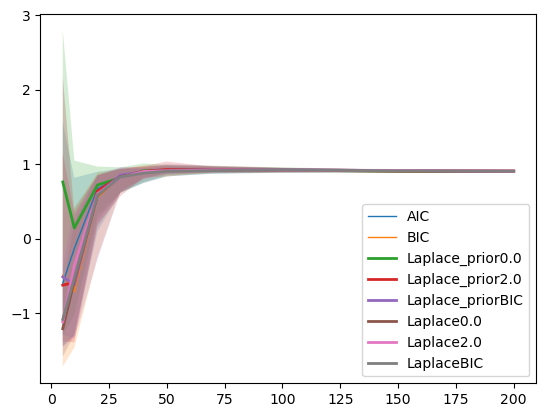

In [20]:
# Matplotlib plot with fill between Q1 and Q3 and the median as the base values
metrics = ["Laplace"]#[ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = [ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#lines = ['', ' ', '--', '-.', '-', ':']
fig, ax = plt.subplots()
for metric in metrics:
    print(metric)
    medians = [total_results[k][metric]["median"] for k in total_results]
    lower = [total_results[k][metric]["Q1"] for k in total_results]
    upper = [total_results[k][metric]["Q3"] for k in total_results]
    x = [k for k in total_results]
    lw = 2.0 if any(text in metric for text in ["Laplace", "Laplace_prior"]) else 1.0
    ax.plot(x, medians, label=metric, linewidth=lw)
    #ax.errorbar(x, medians, yerr=[u-l for l, u in zip(lower, upper)])
    ax.fill_between(x, lower, upper, alpha=0.2)
plt.legend()
#plt.savefig("evaluation/mll_per_datapoint_full.png")
#tikzplotlib.save("evaluation/mll_per_datapoint_full.tex")

In [ ]:
print([kernel for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])
for data_num in total_results:
    print(f"{data_num} & {' & '.join([str(total_results[data_num][kernel]['median']) for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])} \\\\")

# CO2 dataset

In [ ]:
for key in ["MLL", "AIC", "BIC", "Laplace", "Laplace_prior"]:
    print(key)
    all_results = load_results('results/CO2',  key)#, regex_scheme=r_scheme)
    for i, result in enumerate(all_results):
        print(i)
        if key in ["Laplace", "Laplace_prior"]:
            print(deep_dict_get(result, "results/attributes/parameter_punishment"))
        print(deep_dict_get(result, "results/results/test mll"))

In [ ]:

all_results = load_results('results', "Laplace")#, regex_scheme="[0-9].pickle")